## ТЕСТОВОЕ ЗАДАНИЕ / МИНИН ИВАН

### import libraries

In [1]:
import numpy as np
import pandas as pd

import statsmodels
from scipy import stats
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import os

In [2]:
from pandasql import sqldf

pysqldf = lambda x: sqldf(x, globals())

### load data using pandas

In [3]:
DIR = os.getcwd() + "\\data\\"

sessions = pd.read_parquet(DIR + "sessions.parquet", engine="auto")
matches = pd.read_parquet(DIR + "matches.parquet", engine="auto")
ingame_purchases = pd.read_parquet(DIR + "ingame_purchases.parquet", engine="auto")

### exploratory data analysis

Использую свою функцию для быстрого разведочного анализа данных (**EDA**).

In [4]:
# Объявляю функцию
def simple_eda(df):
    print(f'ROWS: {df.shape[0]}', f'COLUMNS: {df.shape[1]}',
          f'DUPLICATED ROWS: {df.duplicated(keep="first").sum()}',
          f'DATA TYPES:\n{df.dtypes}', f'NULL:\n{df.isna().sum()}', 
          f'NOT NULL:\n{df.notna().sum()}', f'NUNIQUE:\n{df.nunique()}', sep='\n\n')

#### датафрейм sessions

In [5]:
simple_eda(sessions)

ROWS: 16880403

COLUMNS: 3

DUPLICATED ROWS: 1170

DATA TYPES:
player_id                       object
install_time       datetime64[ns, UTC]
session_started    datetime64[ns, UTC]
dtype: object

NULL:
player_id          0
install_time       0
session_started    0
dtype: int64

NOT NULL:
player_id          16880403
install_time       16880403
session_started    16880403
dtype: int64

NUNIQUE:
player_id          1530954
install_time       1324042
session_started    2494671
dtype: int64


In [6]:
sessions.sample(3)

,player_id,install_time,session_started
13203366,c8a86b4c47adebc2aa2fa1fdbeb5685d0707be8ce910be...,2020-06-28 22:09:30+00:00,2020-06-29 09:13:45+00:00
3345844,d3f55ed639b0c6c6c1ce35454c485c45d02841624d9c97...,2020-04-05 23:12:05+00:00,2020-06-12 11:28:40+00:00
3989898,5893d978c0366f0fed9c3694604f7658ab45e5de4727e2...,2020-06-20 13:02:58+00:00,2020-06-20 22:15:59+00:00


В датафрейме **sessions** есть 1170 дубликатов строк. Использую функцию drop_duplicates(), которая удаляет все задублированные строки, кроме первой (оригинальной строки).

In [7]:
sessions = sessions.drop_duplicates()

sessions[sessions.duplicated()]

,player_id,install_time,session_started


Поиск продублированных строк не дал результатов, следовательно, имеем отчищенный датафрейм.

#### датафрейм matches

In [8]:
simple_eda(matches)

ROWS: 10000000

COLUMNS: 5

DUPLICATED ROWS: 831

DATA TYPES:
player_id                       object
install_time       datetime64[ns, UTC]
session_started    datetime64[ns, UTC]
ball_name                       object
action_type                     object
dtype: object

NULL:
player_id               0
install_time            0
session_started         0
ball_name               0
action_type        128400
dtype: int64

NOT NULL:
player_id          10000000
install_time       10000000
session_started    10000000
ball_name          10000000
action_type         9871600
dtype: int64

NUNIQUE:
player_id          370005
install_time       331505
session_started    688114
ball_name              49
action_type            10
dtype: int64


В датафрейме **matches** также есть дубликаты строк, удаляю их аналогичным образом.

In [9]:
matches = matches.drop_duplicates()

matches[matches.duplicated()]

,player_id,install_time,session_started,ball_name,action_type


Продублированные строки отсутствуют - имеем отчищенный датафрейм.

#### датафрейм ingame_purchases

In [10]:
simple_eda(ingame_purchases)

ROWS: 334400

COLUMNS: 7

DUPLICATED ROWS: 0

DATA TYPES:
user_id                         object
platform                        object
source                          object
first_spend        datetime64[ns, UTC]
spend_timestamp    datetime64[ns, UTC]
gross_revenue                  float64
item_name                        Int64
dtype: object

NULL:
user_id            0
platform           0
source             0
first_spend        0
spend_timestamp    0
gross_revenue      0
item_name          0
dtype: int64

NOT NULL:
user_id            334400
platform           334400
source             334400
first_spend        334400
spend_timestamp    334400
gross_revenue      334400
item_name          334400
dtype: int64

NUNIQUE:
user_id            111312
platform                2
source                  2
first_spend        110507
spend_timestamp    325645
gross_revenue      334400
item_name              43
dtype: int64


In [11]:
ingame_purchases.sample(3)

,user_id,platform,source,first_spend,spend_timestamp,gross_revenue,item_name
259014,3f4f6fccf2ac30dbf149678476da57680dc7c339d30ab5...,ANDROID,paid,2020-06-15 11:35:44+00:00,2020-07-10 22:00:24+00:00,8.370070,2581138392889728749
294627,c933b79376ba98f85a31f048fa226eee374c0d4d4908d4...,ANDROID,paid,2020-06-22 02:32:12+00:00,2020-06-23 22:43:50+00:00,3.939817,2079916232060640790
27561,daa8e25b24c3c154f0247e9f397ed82833db152a178c02...,ANDROID,paid,2020-07-05 20:37:44+00:00,2020-07-05 20:41:51+00:00,2.392810,-4763743233839592723


### make queries using pandasql 

> Используя `pandasql`, мой ноутбук не смог переварить практически **16,9 млн. строк из датафрейма sessions** (*ошибка Memmory Error*). Поэтому, расчеты я сделал через Pandas, но также после расчетов прикладываю sql-скрипты, которыми я бы считал необходимые метрики.

### DAU calculation

DAU - число **уникальных** пользователей, которые **зашли в игру в течение суток как минимум раз**. Для расчетов использую датафрейм **sessions**, т.к. в нем содержится информация о заходах (сессиях) пользователей в игру.

1. Создам столбец с датой сессии, для этого **session_started** необходимо преобразовать из вида datetime в date.
2. Считаю количество **уникальных** пользователей за каждый день.

In [12]:
sessions['date'] = sessions['session_started'].dt.date
sessions['date'] = pd.to_datetime(sessions['date'])

dau = sessions.groupby('date', as_index=False) \
    .agg({'player_id' : 'nunique'}) \
    .rename(columns={'player_id' : 'dau'}) \
    .sort_values('date')

dau

,date,dau
0,2020-06-01,248883
1,2020-06-02,243715
2,2020-06-03,241874
3,2020-06-04,240717
4,2020-06-05,239860
5,2020-06-06,249954
6,2020-06-07,261440
7,2020-06-08,218095
8,2020-06-09,221331
9,2020-06-10,225798


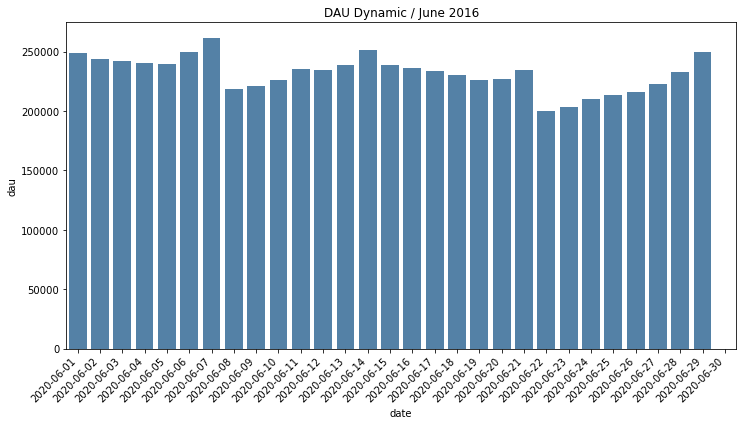

In [13]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(data=dau, x="date", y="dau", color='steelblue')

x_dates = dau['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(title='DAU Dynamic / June 2016')
plt.show()

По графику видно внутри недели есть сезонность посещаемости игры: пик приходится на выходные - суббота и воскресенье.

Прикладываю SQL-скрипт, который использовался бы для расчета DAU.

> В `pandasql` используется синтаксис SQLite, колонку **session_started** преобразую из datetime в date через **strftime('%Y-%m-%d')**

In [14]:
"""
select 
  strftime('%Y-%m-%d', session_started) as date, 
  count(distinct player_id) as DAU 
from 
  sessions
group by 
  strftime('%Y-%m-%d', session_started) 
order by 
  strftime('%Y-%m-%d', session_started) asc
""";

#### MAU calculation

**MAU** - число **уникальных** пользователей, которые **зашли в игру в течении месяца хотя бы раз**. Для расчета MAU также использую датафрейм **sessions**.

Важно отметить, что **MAU != SUM(DAU)**

In [15]:
sessions['month'] = sessions['session_started'].dt.strftime('%Y-%m')
sessions['month'] = pd.to_datetime(sessions['month'])

mau = sessions.groupby('month', as_index=False) \
    .agg({'player_id' : 'nunique'}) \
    .rename(columns={'player_id' : 'mau'}) \
    .sort_values('month')

mau

,month,mau
0,2020-06-01,1530954


MAU июня **1 530 954 пользователя**, однако необходимо учитывать тот факт, что за 30 число этого месяца мы имеем маленькое количество записей (скорее всего у нас не до конца собраны данные за этот день), поэтому реальный MAU будет больше, и составит **примерно 1 759 523 пользователей** (получившийся MAU + медиана MAU по вторникам).

Прикладываю SQL-скрипт, который использовался бы для расчета MAU.

> Колонку **session_started** привожу к виду месяца через **strftime('%Y-%m')**

In [16]:
"""
select 
  strftime('%Y-%m', session_started) as month, 
  count(distinct player_id) as MAU 
from 
  sessions
group by 
  strftime('%Y-%m', session_started) 
order by 
  strftime('%Y-%m', session_started) asc

""";

#### ARPU calculation

**ARPU** - средня выручка с одного пользователя. В расчетах ARPU **учитываются как платящие, так и не платящие пользователи**.

ARPU буду считать за месяц, для этого необходимо подсчитать выручку за месяц, и затем разделить на MAU.

In [17]:
ingame_purchases['month'] = ingame_purchases['spend_timestamp'].dt.strftime('%Y-%m')
ingame_purchases['month'] = pd.to_datetime(ingame_purchases['month'])

arpu_df = ingame_purchases.groupby('month', as_index=False) \
    .agg({'gross_revenue' : 'sum'}) \
    .rename(columns={'gross_revenue' : 'total_revenue'}) \
    .merge(mau, on='month')

arpu_df['ARPU'] = arpu_df['total_revenue']/arpu_df['mau']

arpu_df

,month,total_revenue,mau,ARPU
0,2020-06-01,442755.73755,1530954,0.289203


**ARPU июня составляет 0,29$**

Прикладываю SQL-скрипт, который использовался бы для расчета ARPU.

In [18]:
"""
with mau_df as
(select 
  strftime('%Y-%m', session_started) as month, 
  count(distinct player_id) as MAU 
from 
  sessions
group by 
  strftime('%Y-%m', session_started)),

revenue_df as
(select
  strftime('%Y-%m', spend_timestamp) as month,
  sum(gross_revenue) as total_revenue   
from
  ingame_purchases
group by
  strftime('%Y-%m', spend_timestamp))
    
select
  r.month,
  r.total_revenue,
  m.MAU,
  r.total_revenue/m.MAU as ARPU
from
  revenue_df r
inner join mau_df m on m.month = r.month

""";

### Find insights in data

#### LTV calculation

In [19]:
# Посчитайте LTV на рассматриваемом временном интервале

Я буду считать Lifetime Value методом **когортного анализа**. 

Для расчетов необходимо:
1. Для каждого пользователя определить его когорту.
2. Для каждой когорты в каждый n-ый месяц необходимо посчитать Revenue и количество активных пользователей когорты, и далее, на их основе расчитать ARPU.
3. Финальный шаг: для каждой когорты расчитываем сумму ARPU за все месяца - **получаем LTV когорты.**

Но, в связи с тем, что в датафрейме **sessions** имеются данные по посещаемости **только за июнь 2016 года**, количество активных пользователей и ARPU можно расчитать только для когорты этого периода (т.е. рассматриваемым периодом в данном задании будет июнь 2016 года).

*Но, если бы у нас были все необходимые данные, то я бы считал LTV и все сопутствующие метрики, как в решении ниже:*

Для каждого пользователя найду его когорту. За когорту буду считать **месяц, в который была установлена игра.** Для этого использую данные из датафрейма **sessions**, столбец **install_time**.

In [20]:
player_info = sessions[['player_id', 'install_time']].drop_duplicates()

player_info['cohort_month'] = player_info['install_time'].dt.strftime('%Y-%m')
player_info['cohort_month'] = pd.to_datetime(player_info['cohort_month'])
player_info.rename(columns={'player_id' : 'user_id'}, inplace=True)


player_info.head()

,user_id,install_time,cohort_month
0,62955d9e03a8c30126b10722b63219684a01410ed2035b...,2020-05-01 17:14:34+00:00,2020-05-01
1,afb81c5ae45b3ee436b26c5d65b3e4f7717e29182248aa...,2020-05-16 10:27:04+00:00,2020-05-01
2,99a9a0485e81462194f59660eb8ff85b834517a666e722...,2020-05-08 22:16:43+00:00,2020-05-01
3,fcfac2097c8e03c225f2b27a843fda2ef858ab4ce43347...,2020-04-29 20:43:12+00:00,2020-04-01
4,5c360eb4277ab76a341b7b7080b3afcdca70a041034ca2...,2020-05-04 05:45:51+00:00,2020-05-01


Для каждой когорты в каждый n-ый месяц (назову его cohort_idx) считаю **количество активных пользователей когорты**.

В столбце **cohort_idx** считается разница в месяцах между месяцем совершения покупки и месяцем когорты. *Например, если пользователь пришел в сентябре и сделал покупку в декабре, то индекс когорты будет равен 3 (12 - 9).*

In [21]:
sessions.rename(columns={'player_id' : 'user_id'}, inplace=True)
cohorts = sessions.merge(player_info[['user_id', 'cohort_month']], on='user_id', how='left')

cohorts['cohort_idx'] = (((cohorts['month'].dt.year - cohorts['cohort_month'].dt.year) * 12) + 
                    (cohorts['month'].dt.month - cohorts['cohort_month'].dt.month))
    
cohorts = cohorts.groupby(['month', 'cohort_month', 'cohort_idx'], as_index=False) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns={'user_id': 'cohort_active_users'})

cohorts.tail()

,month,cohort_month,cohort_idx,cohort_active_users
14,2020-06-01,2020-02-01,4,5058
15,2020-06-01,2020-03-01,3,93405
16,2020-06-01,2020-04-01,2,146632
17,2020-06-01,2020-05-01,1,278341
18,2020-06-01,2020-06-01,0,993780


К датафрейму **ingame_purchases**, который содержит информацию о покупках пользователей, приджоиню к каждому пользователю его когорту.

In [22]:
df = ingame_purchases.merge(player_info[['user_id', 'cohort_month']], on='user_id', how='left')

df['cohort_idx'] = (((df['month'].dt.year - df['cohort_month'].dt.year) * 12) + 
                    (df['month'].dt.month - df['cohort_month'].dt.month))

df.sample(3)

,user_id,platform,source,first_spend,spend_timestamp,gross_revenue,item_name,month,cohort_month,cohort_idx
215780,2932364eefcf9b662c73a6c38ab82ac5ecdf03e1e338a8...,ANDROID,paid,2020-08-13 00:31:59+00:00,2020-08-14 03:13:36+00:00,6.069030,-2630582794390405076,2020-08-01,NaT,NaN
169621,26062d33c2e08745170bede5f57bb1a64bb0732dd3b2b1...,ANDROID,paid,2020-08-10 13:08:54+00:00,2020-08-10 13:08:54+00:00,2.162145,-4763743233839592723,2020-08-01,NaT,NaN
103071,f3db6459fb9ff4dbff0a3034e177aecce87ba7574616ad...,ANDROID,paid,2020-08-12 19:51:54+00:00,2020-08-12 19:57:02+00:00,3.391764,9009334556150351728,2020-08-01,NaT,NaN


Далее для каждой когорты в каждый n-ый месяц (cohort_idx) считаю метрики:
- Revenue
- Paying Users
- Активных пользователей когорты, ARPU (столбцы будут содержать пропуски, т.к. нет данных о сессиях в другие месяцы, кроме июня 2016 года)
- *Дополнительно можно расчитать ARPPU*

In [23]:
ltv_df = df.groupby(['cohort_month', 'cohort_idx'], as_index = False) \
    .agg({'gross_revenue' : 'sum', 'user_id' : 'nunique'}) \
    .rename(columns={'user_id' : 'paying_users'})

ltv_df['cohort_idx'] = ltv_df['cohort_idx'].astype(int)

ltv_df = ltv_df \
    .merge(cohorts[['cohort_month', 'cohort_idx', 'cohort_active_users']], on=['cohort_month', 'cohort_idx'], how='left')
    
ltv_df['arpu'] = ltv_df['gross_revenue']/ltv_df['cohort_active_users']
ltv_df['arppu'] = ltv_df['gross_revenue']/ltv_df['paying_users']

ltv_df

,cohort_month,cohort_idx,gross_revenue,paying_users,cohort_active_users,arpu,arppu
0,2018-12-01,18,27.949536,4,64.0,0.436712,6.987384
1,2018-12-01,19,9.345185,2,NaN,NaN,4.672593
2,2018-12-01,20,6.562309,1,NaN,NaN,6.562309
3,2019-01-01,17,2.723765,1,134.0,0.020327,2.723765
4,2019-01-01,18,6.455000,1,NaN,NaN,6.455000
5,2019-01-01,19,25.944146,2,NaN,NaN,12.972073
6,2019-02-01,16,15.874800,1,94.0,0.168881,15.874800
7,2019-02-01,17,17.256151,2,NaN,NaN,8.628076
8,2019-03-01,15,85.849647,8,367.0,0.233923,10.731206
9,2019-03-01,16,159.641347,10,NaN,NaN,15.964135


**Результат:**

**LTV когорты июня 2016 года ~ 0,35$**

Также, на основе полученного датафрейма, можно расчитать кумулятивный ARPPU.

In [24]:
ltv_df.groupby(['cohort_month', 'cohort_idx']).sum() \
    .groupby(level=0).cumsum().reset_index() \
    .query('cohort_month == "2020-06-01"')[['cohort_month', 'arppu']]

,cohort_month,arppu
53,2020-06-01,16.177117
54,2020-06-01,41.732906
55,2020-06-01,66.598231


Т.е. можно сказать, что в среднем один платящий пользователь из когорты июня 2016 года за 3 месяца принес нам **66,6$**.

Так выглядела бы **когортная матрица**, если бы имелись полные данные (представьте, что пустоты над диагональю, были бы заполнены значениями). Тогда сумма ARPU по каждой строке = LTV когорты.

In [25]:
ltv_df.pivot_table(index = 'cohort_month', columns = 'cohort_idx', values = 'arpu').fillna('')

cohort_idx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
cohort_month,,,,,,,,,,,,,,,,,,,
2018-12-01,,,,,,,,,,,,,,,,,,,0.436712
2019-01-01,,,,,,,,,,,,,,,,,,0.020327,
2019-02-01,,,,,,,,,,,,,,,,,0.168881,,
2019-03-01,,,,,,,,,,,,,,,,0.233923,,,
2019-04-01,,,,,,,,,,,,,,,0.159323,,,,
2019-05-01,,,,,,,,,,,,,,0.338862,,,,,
2019-06-01,,,,,,,,,,,,,0.460666,,,,,,
2019-07-01,,,,,,,,,,,,0.451377,,,,,,,
2019-08-01,,,,,,,,,,,0.244209,,,,,,,,


In [26]:
# Какой предмет обладает наибольшим ARPPU

In [27]:
items_purchases = ingame_purchases.groupby('item_name', as_index=False) \
    .agg({'gross_revenue' : 'sum', 'user_id' : 'nunique', 'source' : 'count'}) \
    .rename(columns={'user_id' : 'users', 'source' : 'purchases'})

items_purchases['apc'] = round(items_purchases['purchases']/items_purchases['users'], 2)
items_purchases['arppu'] = round(items_purchases['gross_revenue']/items_purchases['users'], 2)

items_purchases.sort_values('arppu', ascending=False).head(3)

,item_name,gross_revenue,users,purchases,apc,arppu
38,8383795301275726340,96055.040458,475,956,2.01,202.22
4,-7781756995220667371,16934.665890,160,160,1.00,105.84
21,-1392252324343529151,10217.467829,98,98,1.00,104.26


Наибольшим ARPPU обладает предмет **"8383795301275726340"**, к тому же, данный предмет обладает высокой частотой покупок (**APC**).

In [28]:
items_purchases_m = ingame_purchases.groupby(['item_name', 'month'], as_index=False) \
    .agg({'gross_revenue' : 'sum', 'user_id' : 'nunique', 'source' : 'count'}) \
    .rename(columns={'user_id' : 'users', 'source' : 'purchases'})

items_purchases_m['apc'] = round(items_purchases_m['purchases']/items_purchases_m['users'], 2)
items_purchases_m['arppu'] = round(items_purchases_m['gross_revenue']/items_purchases_m['users'], 2)

items_purchases_m.sort_values('arppu', ascending=False).head(3)

,item_name,month,gross_revenue,users,purchases,apc,arppu
82,8383795301275726340,2020-06-01,22849.580924,101,229,2.27,226.23
84,8383795301275726340,2020-08-01,49121.120504,277,486,1.75,177.33
83,8383795301275726340,2020-07-01,24084.339030,157,241,1.54,153.40


В разрезе месяцев также видно, что данный предмет является №1 по ARPPU.

In [29]:
# Сезонность внутри дня и недели

Для определения сезонности покупок я буду считать **коэффициент сезонности**.

Коэффициент сезонности показывает, как возрастает или падает количество покупкок в определённый период, в нашем случае:
- сезонность внутри недели - это количество покупок по дням недели (пн, вт, ср, и т.д.), 
- сезонность внутри дня - это количество покупок по часам.

Чтобы рассчитать коэффициент сезонности, необходимо найти количество покупок для каждого дня/часа и общее количество покупок за имеющийся период. Делим покупки каждого дня/часа на общее количество покупок - получаем набор коэффициентов.

In [30]:
def season_type(df, stype):
    if stype=='week':
        
        df['day_of_week'] = df['spend_timestamp'].dt.day_name()
        df['day_rank'] = df['spend_timestamp'].dt.weekday
        df['week'] = df['spend_timestamp'].dt.isocalendar().week
        
        d1 = df.groupby(['day_rank','day_of_week'], as_index=False) \
                .agg({'user_id' : 'count'}) \
                .rename(columns={'user_id' : 'purchases_per_day'})
        
        d1['seasonality'] = round(d1['purchases_per_day']/df.spend_timestamp.count(), 4)
        
        seasonality = d1[['day_of_week', 'seasonality']].to_numpy()
    else:
        
        df['hour'] = df['spend_timestamp'].dt.hour
        
        d2 = df.groupby('hour', as_index=False) \
                .agg({'user_id' : 'count'}) \
                .rename(columns={'user_id' : 'purchases_per_hour'})
        
        d2['seasonality'] = round(d2['purchases_per_hour']/df.spend_timestamp.count(), 4)
        
        seasonality = d2[['hour', 'seasonality']].to_numpy()
    return seasonality

In [31]:
stype='week'

week_seas = season_type(ingame_purchases, stype)

week_seas

array([['Monday', 0.179],
       ['Tuesday', 0.1389],
       ['Wednesday', 0.1328],
       ['Thursday', 0.1338],
       ['Friday', 0.1358],
       ['Saturday', 0.1377],
       ['Sunday', 0.1418]], dtype=object)

In [32]:
week_seas = pd.DataFrame(week_seas, columns = ['day_of_week','seasonality'])

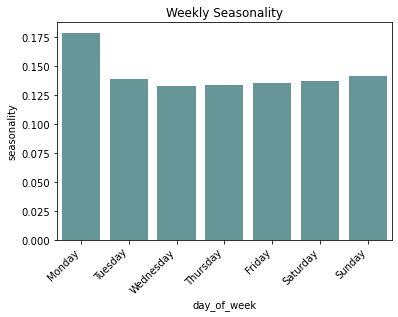

In [33]:
ax = sns.barplot(data=week_seas, x='day_of_week', y='seasonality', color='cadetblue');
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set(title='Weekly Seasonality')

plt.show()

In [34]:
stype='day'

day_seas = season_type(ingame_purchases, stype)

day_seas

array([[ 0.    ,  0.0527],
       [ 1.    ,  0.0473],
       [ 2.    ,  0.0469],
       [ 3.    ,  0.0424],
       [ 4.    ,  0.0386],
       [ 5.    ,  0.0359],
       [ 6.    ,  0.0326],
       [ 7.    ,  0.032 ],
       [ 8.    ,  0.0303],
       [ 9.    ,  0.0311],
       [10.    ,  0.0323],
       [11.    ,  0.035 ],
       [12.    ,  0.0387],
       [13.    ,  0.042 ],
       [14.    ,  0.0445],
       [15.    ,  0.0457],
       [16.    ,  0.047 ],
       [17.    ,  0.0473],
       [18.    ,  0.0468],
       [19.    ,  0.0472],
       [20.    ,  0.0482],
       [21.    ,  0.0467],
       [22.    ,  0.0452],
       [23.    ,  0.0435]])

In [35]:
day_seas = pd.DataFrame(day_seas, columns = ['hour','seasonality'])

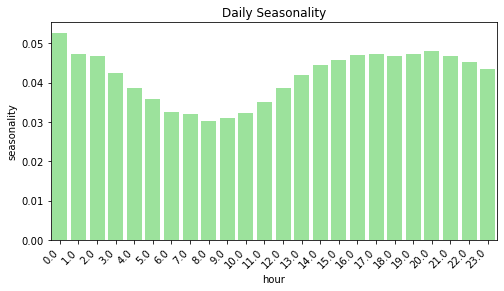

In [36]:
plt.figure(figsize=(8,4))

ax = sns.barplot(data=day_seas, x='hour', y='seasonality', color='lightgreen')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set(title='Daily Seasonality')

plt.show()

In [37]:
# Какими шарами играют чаще

In [38]:
def top_balls(df, top):
    balls_name = df.groupby('ball_name', as_index=False) \
                    .agg({'session_started' : 'count'}) \
                    .rename(columns={'session_started' : 'matches'}) \
                    .sort_values('matches', ascending=False).ball_name.tolist()[0:top]
    return balls_name

In [39]:
top = int(input('select number of tops: '))
top_balls(matches, top)

select number of tops: 5


['StrikeBall10', 'StrikeBall8', 'StrikeBall1', 'SplitBall8', 'BeginnerBall3']

In [40]:
# Каким шаром проще выбить страйк, сплит и другие action_type?
# rate - [ball_name: str, action_type: str, rate_value: float16]
# rate_value - доля использования шара в рамках конкретного action_type

In [41]:
def action_rate(df): 
    df1 = df.groupby(['action_type', 'ball_name'], as_index=False) \
            .agg({'session_started' : 'count'}) \
            .rename(columns={'session_started' : 'action_count'}) \
            .sort_values(['action_type', 'action_count'], ascending=False) \
            .groupby(['action_type', 'ball_name']).head()
    df2 = df1.groupby('action_type', as_index=False) \
            .agg({'action_count' : 'sum'}) \
            .rename(columns={'action_count' : 'total_count'})
    rate = df1.merge(df2, on='action_type', how='left') \
            .assign(rate_value=lambda x: round(x.action_count/x.total_count*100,2)) \
            .groupby('action_type').first().reset_index()[['ball_name', 'action_type', 'rate_value']] \
            .query('action_type != "Miss"').values.tolist()
 
    return rate

In [42]:
action_rate(matches)

[['StrikeBall10', 'Double', 26.1],
 ['StrikeBall10', 'Hambone', 15.72],
 ['StrikeBall10', 'Nice', 16.12],
 ['StrikeBall10', 'Open', 9.46],
 ['StrikeBall8', 'Perfect', 34.88],
 ['SplitBall8', 'Spare', 11.25],
 ['StrikeBall10', 'Split', 12.74],
 ['StrikeBall10', 'Strike', 29.34],
 ['StrikeBall10', 'Turkey', 20.34]]

#### Conclusions

In [43]:
# Какие выводы можно сделать, основываясь на данных:

**В тройку лидеров по популярности входят strike-шары:** StrikeBall10, StrikeBall8, StrikeBall1

**StrikeBall10** является самым часто используемым шаром для выбивания **Strike, Double, Turkey, Hambone и Split**. **Spare** чаще выбивают шаром **SplitBall8**



**Больше всего покупок совершается по понедельникам**.

Проверю, как распределяется количество покупок в разрезе дня и часа по месяцам (июнь, июль, август), а также посмотрю на динамику покупок.

In [44]:
ingame_purchases['date'] = ingame_purchases['spend_timestamp'].dt.date

matrix_june = ingame_purchases.groupby(['month', 'day_of_week', 'hour'], as_index=False) \
    .agg({'user_id' : 'count'}) \
    .query('month == "2020-06-01"') \
    .rename(columns={'user_id' : 'purchases'}) \
    .pivot_table(index='hour', columns='day_of_week', values='purchases') \
    [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']] \
    .round()

matrix_july = ingame_purchases.groupby(['month', 'day_of_week', 'hour'], as_index=False) \
    .agg({'user_id' : 'count'}) \
    .query('month == "2020-07-01"') \
    .rename(columns={'user_id' : 'purchases'}) \
    .pivot_table(index='hour', columns='day_of_week', values='purchases') \
    [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']] \
    .round()

matrix_aug = ingame_purchases.groupby(['month', 'day_of_week', 'hour'], as_index=False) \
    .agg({'user_id' : 'count'}) \
    .query('month == "2020-08-01"') \
    .rename(columns={'user_id' : 'purchases'}) \
    .pivot_table(index='hour', columns='day_of_week', values='purchases') \
    [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']] \
    .round()

purchases_dynamic = ingame_purchases.groupby(['month', 'date', 'day_of_week']) \
    .agg({'spend_timestamp' : 'count', 'gross_revenue' : 'sum'}) \
    .rename(columns={'spend_timestamp' : 'purchases'}).reset_index()

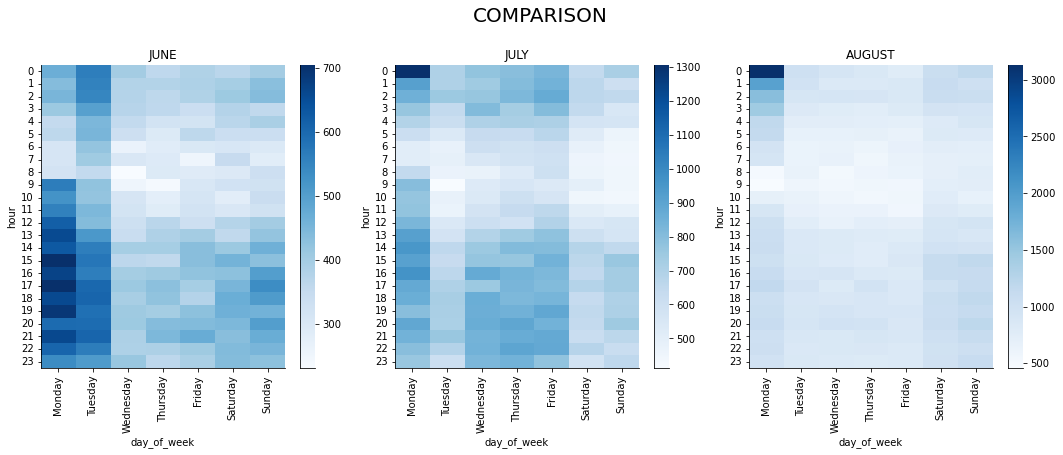

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

fig.tight_layout(pad=1.8)

fig.suptitle('COMPARISON', size=20, y=1.1)

sns.heatmap(ax=axes[0], data=matrix_june, cmap='Blues').set_title('JUNE')
sns.heatmap(ax=axes[1], data=matrix_july, cmap='Blues').set_title('JULY')
sns.heatmap(ax=axes[2], data=matrix_aug, cmap='Blues').set_title('AUGUST')
sns.despine()

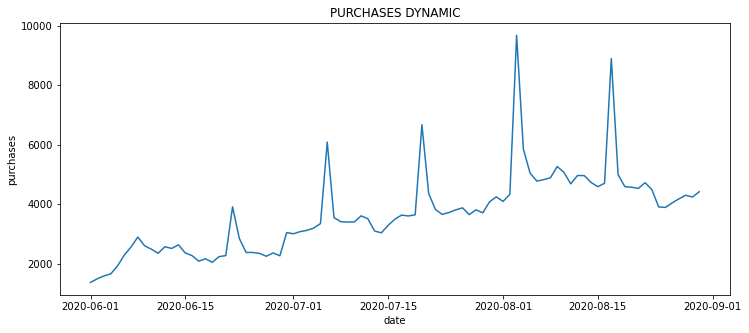

In [46]:
plt.figure(figsize=(12,5))
sns.lineplot(data=purchases_dynamic, x="date", y="purchases").set_title('PURCHASES DYNAMIC')
plt.show()

**Наибольшее число покупок дейсвительно происходит по понедельникам, но с определенным паттерном:** наблюдаем аномальное количество покупок 8 и 22 июня, 6 и 20 июля, 3 и 17 августа - **т.е. ровно через неделю (скорее всего это связано Сезоном Лиги!?)** Это также может объяснять аномальное количество покупок в 12 ночи по понедельникам, т.к. новый сезон начинается в полночь (UTC).

Также **в целом наблюдается динамика роста количества покупок**, что может является следствием разных факторов: сезонность, маркетинговые кампании и т.д.

Посмотрим на динамику покупок и выручки в разрезе платформ и источника.

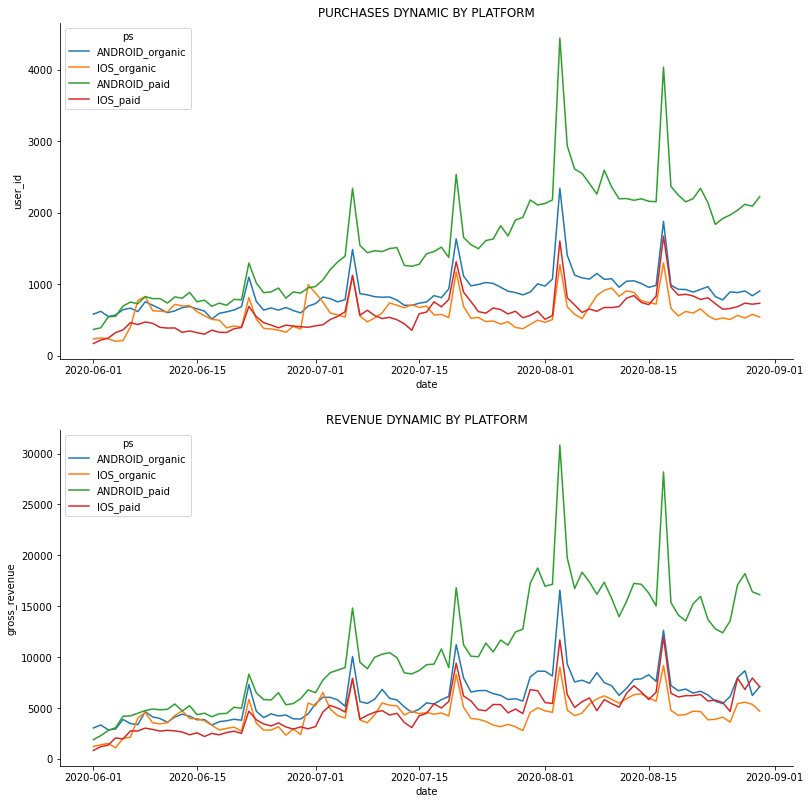

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

fig.tight_layout(pad=5)

sns.lineplot(ax=axes[0], data=ingame_purchases.groupby(['date', 'source', 'platform']) \
                                    .agg({'user_id' : 'count'}).reset_index() \
                                    .assign(ps=lambda x: x.platform + '_' + x.source),
             x="date", y="user_id", hue="ps") \
    .set_title('PURCHASES DYNAMIC BY PLATFORM')
sns.lineplot(ax=axes[1], data=ingame_purchases.groupby(['date', 'source', 'platform']) \
                                    .agg({'gross_revenue' : 'sum'}).reset_index() \
                                    .assign(ps=lambda x: x.platform + '_' + x.source),
             x="date", y="gross_revenue", hue="ps") \
    .set_title('REVENUE DYNAMIC BY PLATFORM')
sns.despine()

По графикам можно предположить, что **с конца июня - начала июля начался закупаться трафик**. 

В июне распределение покупок между органикой и купленным трафиком имеет невысокую вариацию, **с июля количество покупок "закупленных" явно превышает количеству покупок у "органики"**. При этом, **в игру приходят преимущественно пользователи Android.** Также, предполагаю, что основное "ядро" игры - пользователи Android.

### * Find impact of seasonal feature

In [48]:
# Посчитайте количество ежедневных сессий за июль. Чем объяняется вариация? Как можно вычислить эффект сезонной составляющей?
# Оцените относительное внияния недельной сезонности на сессии.
# Можно использовать scipy/statsmodels, либо импортировать другую библиотеку